In [13]:
%load_ext cython
import numpy as np

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [19]:
%%cython
# cython: boundscheck=False, wraparound=False, nonecheck=False
import numpy as np
cimport numpy as np
from libc.math cimport sqrt, fabs

# No ctypedef at module scope, use np.ndarray in function signatures

cdef inline double length(np.ndarray[np.float64_t, ndim=1] v):
    cdef int i
    cdef double s = 0.0
    for i in range(v.shape[0]):
        s += v[i] * v[i]
    return sqrt(s)

def normalize(np.ndarray[np.float64_t, ndim=1] v):
    cdef double norm = length(v)
    cdef int i
    cdef np.ndarray[np.float64_t, ndim=1] result = np.empty(v.shape[0], dtype=np.float64)
    for i in range(v.shape[0]):
        result[i] = v[i] / norm
    return result

cdef inline double dot(np.ndarray[np.float64_t, ndim=1] a, np.ndarray[np.float64_t, ndim=1] b):
    cdef int i
    cdef double s = 0.0
    for i in range(a.shape[0]):
        s += a[i] * b[i]
    return s

def cross(np.ndarray[np.float64_t, ndim=1] a, np.ndarray[np.float64_t, ndim=1] b):
    cdef np.ndarray[np.float64_t, ndim=1] c = np.empty(3, dtype=np.float64)
    c[0] = a[1]*b[2] - a[2]*b[1]
    c[1] = a[2]*b[0] - a[0]*b[2]
    c[2] = a[0]*b[1] - a[1]*b[0]
    return c

cdef double sdCylinder(np.ndarray[np.float64_t, ndim=1] p, double h, double r):
    cdef double d0 = length(np.array([p[0], p[2]], dtype=np.float64))
    d0 = fabs(d0) - r
    cdef double d1 = fabs(p[1]) - h
    cdef double m = max(d0, d1)
    cdef double dist = 0.0
    if m > 0.0:
        dist = sqrt(max(d0, 0.0)**2 + max(d1, 0.0)**2)
    else:
        dist = m
    return dist

cdef double map_func(np.ndarray[np.float64_t, ndim=1] pos):
    return sdCylinder(pos, 0.3, 0.2)

def calcNormal(np.ndarray[np.float64_t, ndim=1] pos):
    cdef double eps = 0.0005
    cdef np.ndarray[np.float64_t, ndim=1] e = np.array([1.0, -1.0], dtype=np.float64) * 0.5773
    cdef np.ndarray[np.float64_t, ndim=1] n = np.zeros(3, dtype=np.float64)

    n[0] = e[0]*map_func(pos + np.array([e[0], e[1], e[1]]) * eps) + \
           e[1]*map_func(pos + np.array([e[1], e[0], e[0]]) * eps) + \
           e[1]*map_func(pos + np.array([e[1], e[0], e[1]]) * eps) + \
           e[0]*map_func(pos + np.array([e[0], e[0], e[0]]) * eps)

    n[1] = e[0]*map_func(pos + np.array([e[1], e[0], e[1]]) * eps) + \
           e[1]*map_func(pos + np.array([e[0], e[1], e[0]]) * eps) + \
           e[0]*map_func(pos + np.array([e[1], e[0], e[0]]) * eps) + \
           e[1]*map_func(pos + np.array([e[0], e[0], e[1]]) * eps)

    n[2] = e[0]*map_func(pos + np.array([e[1], e[1], e[0]]) * eps) + \
           e[1]*map_func(pos + np.array([e[0], e[1], e[1]]) * eps) + \
           e[0]*map_func(pos + np.array([e[0], e[1], e[0]]) * eps) + \
           e[1]*map_func(pos + np.array([e[1], e[0], e[1]]) * eps)

    return normalize(n)

def ray_march(np.ndarray[np.float64_t, ndim=1] ro, np.ndarray[np.float64_t, ndim=1] rd):
    cdef int i
    cdef double t = 0.0
    cdef np.ndarray[np.float64_t, ndim=1] pos
    cdef double dist

    cdef int MAX_STEPS = 256
    cdef double MAX_DIST = 3.0
    cdef double EPSILON = 1e-4

    for i in range(MAX_STEPS):
        pos = ro + t * rd
        dist = map_func(pos)
        if dist < EPSILON:
            return t, pos
        if t > MAX_DIST:
            break
        t += dist
    return -1, None

def render():
    cdef int WIDTH = 1000
    cdef int HEIGHT = 1000
    cdef int x, y
    cdef double aspect_ratio = WIDTH / HEIGHT

    cdef np.ndarray[np.float64_t, ndim=1] CAM_POS = np.array([1.0, 0.4, 1.0], dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] CAM_TARGET = np.array([0.0, 0.0, 0.0], dtype=np.float64)

    cdef np.ndarray[np.float64_t, ndim=1] forward = normalize(CAM_TARGET - CAM_POS)
    cdef np.ndarray[np.float64_t, ndim=1] right = normalize(cross(forward, np.array([0,1,0], dtype=np.float64)))
    cdef np.ndarray[np.float64_t, ndim=1] up = cross(right, forward)

    cdef np.ndarray[np.float64_t, ndim=3] image = np.zeros((HEIGHT, WIDTH, 3), dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] col = np.zeros(3, dtype=np.float64)
    cdef np.ndarray[np.float64_t, ndim=1] normal
    cdef np.ndarray[np.float64_t, ndim=1] light_dir = normalize(np.array([0.57703, 0.57703, 0.57703], dtype=np.float64))

    cdef double px, py, diff, amb
    cdef double t
    cdef np.ndarray[np.float64_t, ndim=1] pos
    cdef np.ndarray[np.float64_t, ndim=1] rd

    for y in range(HEIGHT):
        for x in range(WIDTH):
            px = (2*(x + 0.5)/WIDTH - 1) * aspect_ratio
            py = 1 - 2*(y + 0.5)/HEIGHT
            rd = normalize(px*right + py*up + 1.5*forward)

            t, pos = ray_march(CAM_POS, rd)
            col[:] = 0.0

            if pos is not None:
                normal = calcNormal(pos)
                diff = max(dot(normal, light_dir), 0.0)
                amb = 0.5 + 0.5 * max(dot(normal, np.array([0,1,0], dtype=np.float64)), 0.0)
                col[:] = np.array([0.2, 0.3, 0.4])*amb + np.array([0.8, 0.7, 0.5])*diff
                # gamma correction
                col[:] = np.sqrt(np.clip(col, 0, 1))

            for i in range(3):
                image[y, x, i] = col[i]

    # Convert to uint8 image (0-255)
    cdef np.ndarray[np.uint8_t, ndim=3] img = np.clip(image * 255, 0, 255).astype(np.uint8)
    print("Done rendering")
    return img


Content of stderr:
In file included from /usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/ndarraytypes.h:1909,
                 from /usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/ndarrayobject.h:12,
                 from /usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/arrayobject.h:5,
                 from /root/.cache/ipython/cython/_cython_magic_6f812f57691cfa87bbfb202eb1547ab085ddf691.c:1253:
/usr/local/lib/python3.11/dist-packages/numpy/_core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~

Done rendering


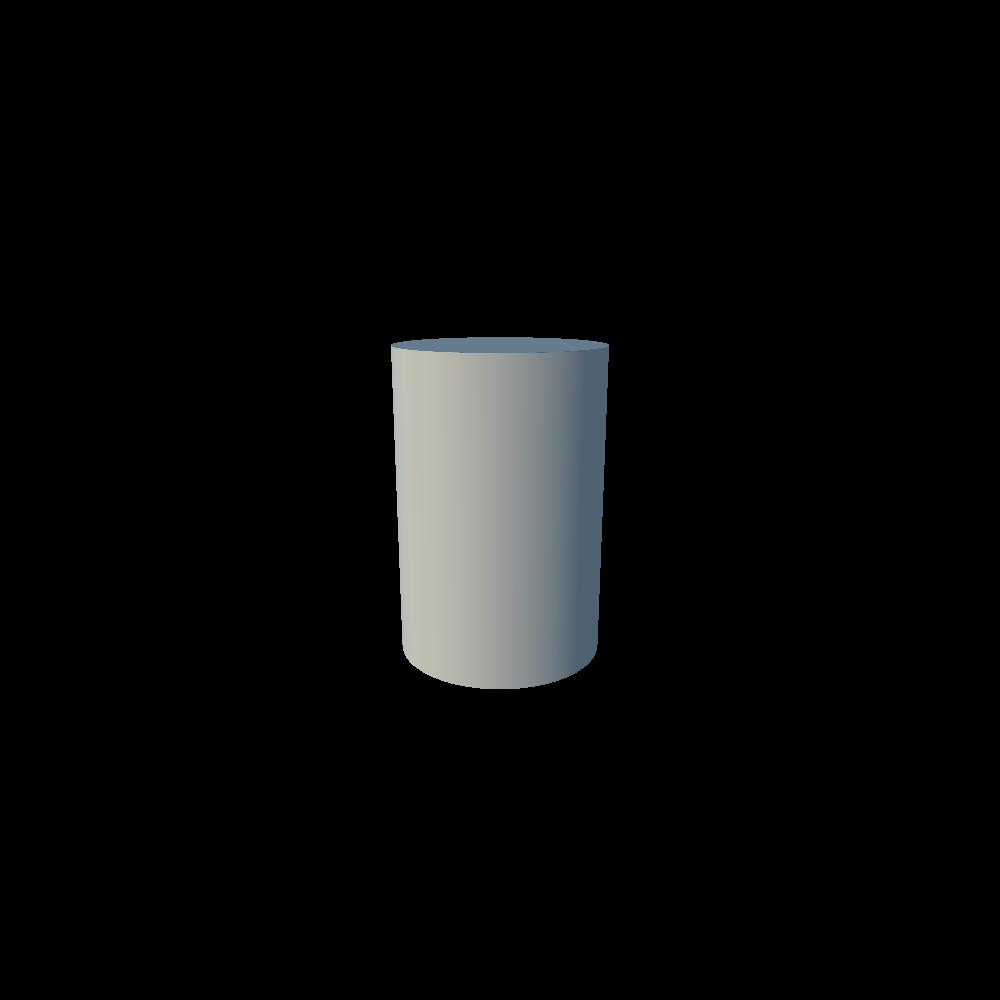

In [20]:
img_array = render()

from PIL import Image


img = Image.fromarray(img_array, 'RGB')
img
